Utilizando el método de Runge Kutta de 4to. orden para resolver las ecuaciones diferenciales.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from IPython.display import clear_output
import time

# Simular datos de entrenamiento para entrenar la red neuronal
def generate_training_data():
    np.random.seed(42)
    X = []
    y = []
    for i in range(1000):
        # Generar errores y sus derivadas al azar
        error = np.random.uniform(-1000, 1000)
        integral = np.random.uniform(-5000, 5000)
        derivative = np.random.uniform(-2000, 2000)

        # Entradas
        X.append([error, integral, derivative])

        # Generar valores de Kp, Ki, Kd en función del error y sus derivadas
        Kp = 60 + 0.1 * error
        Ki = 50 + 0.01 * integral
        Kd = 25 + 0.05 * derivative
        y.append([Kp, Ki, Kd])

    return np.array(X), np.array(y)

# Entrenamos la red neuronal MLP para predecir Kp, Ki, Kd
def train_nn():
    X, y = generate_training_data()
    model = MLPRegressor(hidden_layer_sizes=(60, 60),solver="lbfgs",activation="tanh", learning_rate_init=0.01,alpha=0.1,max_iter=10000, random_state=42)
    model.fit(X, y)
    return model

# Red neuronal entrenada
nn_model = train_nn()

# Parámetros del sistema
F_in_AuCl4 = 0.000166667  # Flujo volumétrico de entrada del precursor de oro (L/s)
F_in_Citrate = 0.000166667  # Flujo volumétrico de entrada del citrato (L/s)
F_out = 2*0.000166667  # Flujo volumétrico de salida (L/s)
V = 0.3  # Volumen del reactor (L)
rho = 1000.0  # Densidad del fluido (kg/L)
Cp = 4.18  # Capacidad calorífica específica del agua (J/g·K)
T_in_AuCl4 = 298.0  # Temperatura de entrada del precursor de oro (K)
T_in_Citrate = 298.0  # Temperatura de entrada del citrato (K)
k0 = 35.48   # 1.5e7 Factor preexponencial de Arrhenius (1/s) estimado
Ea = 55000.0  #75373 Energía de activación (J/mol)
Delta_Hr = -50000.0  # Calor de reacción (J/mol)
T_set = 60 + 273.15  # Temperatura deseada de 60 °C (K)

# Inicializar variables PID
integral = 0.0
previous_error = 0.0  # Inicializar el error previo
previous_time = 0.0   # Inicializar el tiempo previo

# Función para calcular k en función de la temperatura
def k(T):
    return k0 * np.exp(-Ea / (8.314 * T))  # 8.314 es la constante de gases

# Función para verificar si hay valores NaN o infinitos
def check_valid(value, fallback=0.0):
    if np.isnan(value) or np.isinf(value):
        return fallback
    return value

# Inicializar condiciones iniciales del sistema
C_AuCl4_0 = 0.00005  # Concentración inicial de AuCl4^- (mol/L)
C_Citrate_0 = 3.2*0.00005 # Concentración inicial de citrato de sodio (mol/L)
T_0 = 298.0  # Temperatura inicial (K)
y0 = [C_AuCl4_0, C_Citrate_0, T_0]

# Definir el sistema de ecuaciones
def balances_pid_nn(y, t, F_in_AuCl4, F_in_Citrate, F_out, V, rho, Cp, T_in_AuCl4, T_in_Citrate, Delta_Hr, C_AuCl4_in, C_Citrate_in):
    global integral, previous_error, previous_time

    C_AuCl4, C_Citrate, T = y

    # Velocidad de reacción
    k_T = k(T)

    # Balance para AuCl4^-
    dC_AuCl4_dt = (F_in_AuCl4/V) * C_AuCl4_in - (F_out/V) * C_AuCl4 - k_T * C_AuCl4*C_Citrate**1.85

    # Balance para citrato de sodio
    dC_Citrate_dt = (F_in_Citrate/V) * C_Citrate_in - (F_out/V) * C_Citrate - k_T * C_AuCl4*C_Citrate**1.85

    # Calcular el error y sus derivados para el controlador PID
    error = T_set - T
    dt = t - previous_time

    if dt > 0:
        integral += error * dt
        derivative = (error - previous_error) / dt
    else:
        derivative = 0

    previous_error = error
    previous_time = t

    # Asegurar que las entradas para la red neuronal sean válidas
    error = check_valid(error)
    integral = check_valid(integral)
    derivative = check_valid(derivative)

    # Entradas para la red neuronal: [error, integral, derivative]
    nn_input = np.array([[error, integral, derivative]])

    # Ajuste de las ganancias PID con la red neuronal
    try:
        Kp, Ki, Kd = nn_model.predict(nn_input)[0]
    except:
        Kp, Ki, Kd = 150, 50, 20  # Valores predeterminados en caso de error

    # Señal de control PID
    u = Kp * error + Ki * integral + Kd * derivative

    # Balance de energía considerando dos corrientes de entrada
    r_A = k_T * C_AuCl4*C_Citrate**1.85
    dT_dt = (F_in_AuCl4/V) * (T_in_AuCl4 - T) + (F_in_Citrate/V) * (T_in_Citrate - T) + (-Delta_Hr / (rho * Cp)) * r_A + (u / (rho * Cp * V))

    return [dC_AuCl4_dt, dC_Citrate_dt, dT_dt], Kp, Ki, Kd

def runge_kutta_4_step(f, y, t, dt, *args):
    # Realizar el cálculo de k1, k2, k3 y k4
    k1, Kp1, Ki1, Kd1 = f(y, t, *args)
    k2, Kp2, Ki2, Kd2 = f([y[i] + 0.5 * dt * k1[i] for i in range(len(y))], t + 0.5 * dt, *args)
    k3, Kp3, Ki3, Kd3 = f([y[i] + 0.5 * dt * k2[i] for i in range(len(y))], t + 0.5 * dt, *args)
    k4, Kp4, Ki4, Kd4 = f([y[i] + dt * k3[i] for i in range(len(y))], t + dt, *args)

    # Calcular la siguiente iteración del sistema
    y_next = [y[i] + (dt / 6) * (k1[i] + 2 * k2[i] + 2 * k3[i] + k4[i]) for i in range(len(y))] #Regla de Runge Kutta

    # Devolver el valor promedio de las ganancias Kp, Ki, Kd
    Kp_next = (Kp1 + 2*Kp2 + 2*Kp3 + Kp4) / 6
    Ki_next = (Ki1 + 2*Ki2 + 2*Ki3 + Ki4) / 6
    Kd_next = (Kd1 + 2*Kd2 + 2*Kd3 + Kd4) / 6

    return y_next, Kp_next, Ki_next, Kd_next

# Simulación paso a paso con perturbación configurable
def simulate_real_time(perturb_type, perturb_value, perturb_step):
    global y0, F_in_AuCl4, F_in_Citrate, T_in_AuCl4, T_in_Citrate, T_set
    t_step = 1  # Tamaño del paso de tiempo (segundos)
    num_steps = 1000  # Número de pasos de tiempo para la simulación

    # Inicializar listas para almacenar los resultados
    t_vals = []
    C_AuCl4_vals = []
    C_Citrate_vals = []
    T_vals = []
    Kp_vals = []
    Ki_vals = []
    Kd_vals = []

    for i in range(num_steps):
        t = i * t_step
        t_vals.append(t)

        # Simulación de la perturbación según el tipo y valor indicados por el usuario
        if i == perturb_step:
            print(f"Simulación de una perturbación: {perturb_type} cambia a {perturb_value}")
            if perturb_type == "flujo_aucl4":
                F_in_AuCl4 = perturb_value
            elif perturb_type == "flujo_citrato":
                F_in_Citrate = perturb_value
            elif perturb_type == "temperatura_entrada_aucl4":
                T_in_AuCl4 = perturb_value
            elif perturb_type == "temperatura_entrada_citrato":
                T_in_Citrate = perturb_value
            elif perturb_type == "temperatura_deseada":
                T_set = perturb_value

        # Resolver el sistema para el siguiente paso utilizando RK4
        y0, Kp, Ki, Kd = runge_kutta_4_step(balances_pid_nn, y0, t, t_step, F_in_AuCl4, F_in_Citrate, F_out, V, rho, Cp, T_in_AuCl4, T_in_Citrate, Delta_Hr, C_AuCl4_0, C_Citrate_0)

        # Almacenar resultados
        C_AuCl4_vals.append(y0[0])
        C_Citrate_vals.append(y0[1])
        T_vals.append(y0[2])
        Kp_vals.append(Kp)
        Ki_vals.append(Ki)
        Kd_vals.append(Kd)

        # Graficar en tiempo real
        clear_output(wait=True)
        fig, axs = plt.subplots(4, 1, figsize=(10, 12))

        # Graficar las concentraciones de AuCl4^- y citrato
        axs[0].plot(t_vals, C_AuCl4_vals, label='$AuCl4^-$: {} mol/L'.format(round(y0[0],5)), color='blue')
        axs[0].plot(t_vals, C_Citrate_vals, label='Citrato de Na: {} mol/L'.format(round(y0[1],5)), color='green')
        axs[0].set_ylabel('Concentración (M)')
        axs[0].set_xlabel('Tiempo (s)')
        axs[0].legend(loc='upper right')
        #axs[0].grid(True)

        # Graficar la temperatura
        axs[1].plot(t_vals, T_vals, label='{} °K'.format(round(y0[2],4)), color='red')
        axs[1].set_ylabel('Temperatura (K)')
        axs[1].set_xlabel('Tiempo (s)')
        axs[1].legend(loc='upper right')
        #axs[1].grid(True)

        # Graficar las ganancias Kp, Ki, Kd
        axs[2].plot(t_vals, Kp_vals, label='Kp: {}'.format(round(Kp,4)), color='purple')
        axs[2].plot(t_vals, Ki_vals, label='Ki: {}'.format(round(Ki,4)), color='orange')
        axs[2].plot(t_vals, Kd_vals, label='Kd: {}'.format(round(Kd,4)), color='brown')
        axs[2].set_ylabel('Ganacias PID')
        axs[2].set_xlabel('Tiempo (s)')
        axs[2].legend(loc='upper right')
        #axs[2].grid(True)

        # Graficar la señal de control
        axs[3].plot(t_vals, [Kp * (T_set - T) for Kp, T in zip(Kp_vals, T_vals)], label='Señal de Control (u)', color='black')
        axs[3].set_ylabel('Señal de Control (u)')
        axs[3].legend(loc='upper right')
        #axs[3].set_ylim(-500,2000)
        #axs[3].grid(True)

        plt.xlabel('Tiempo (s)')
        plt.tight_layout()
        plt.show()
        time.sleep(0.1)





c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [2]:
plt.rcParams.update({'font.size': 15})

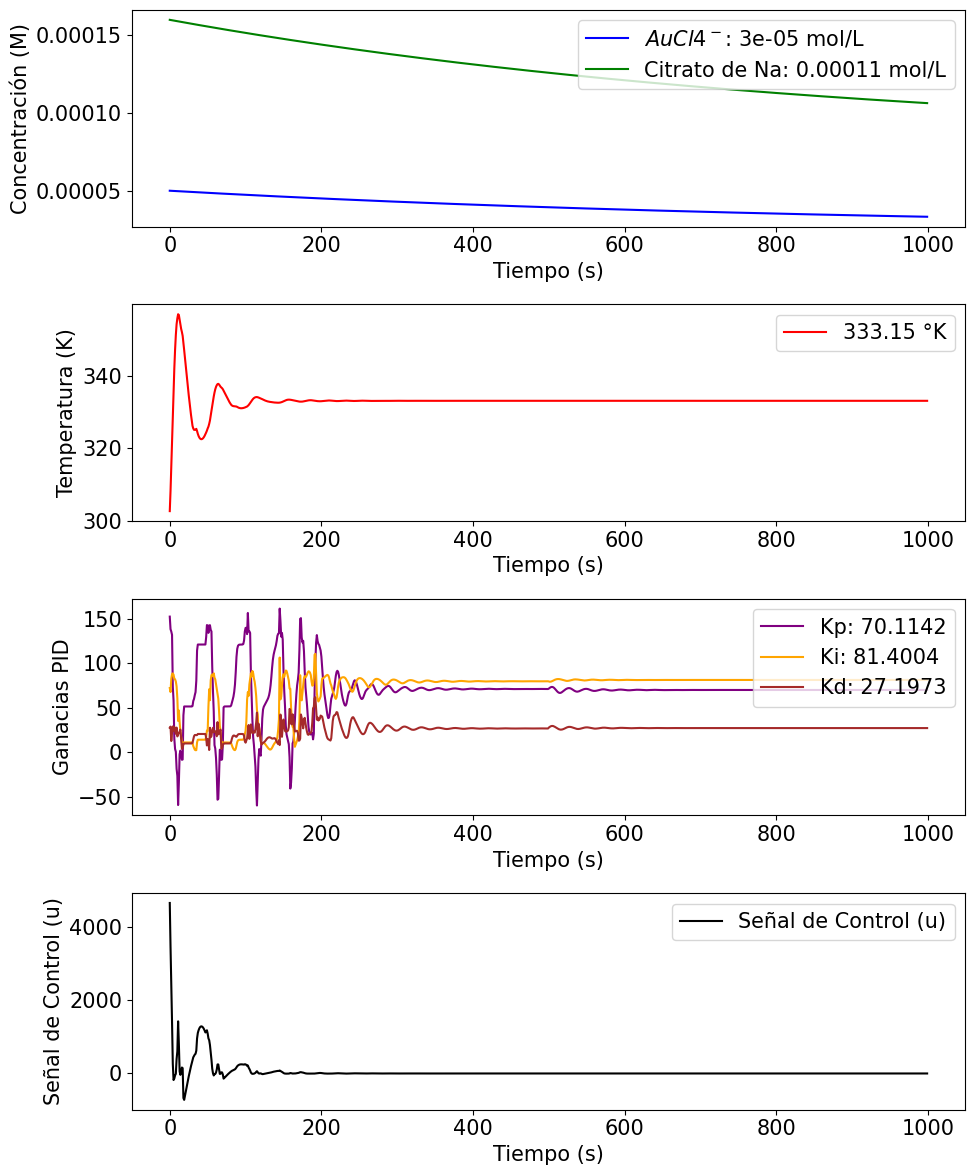

In [18]:
simulate_real_time("temperatura_entrada_aucl4", 290, 500)


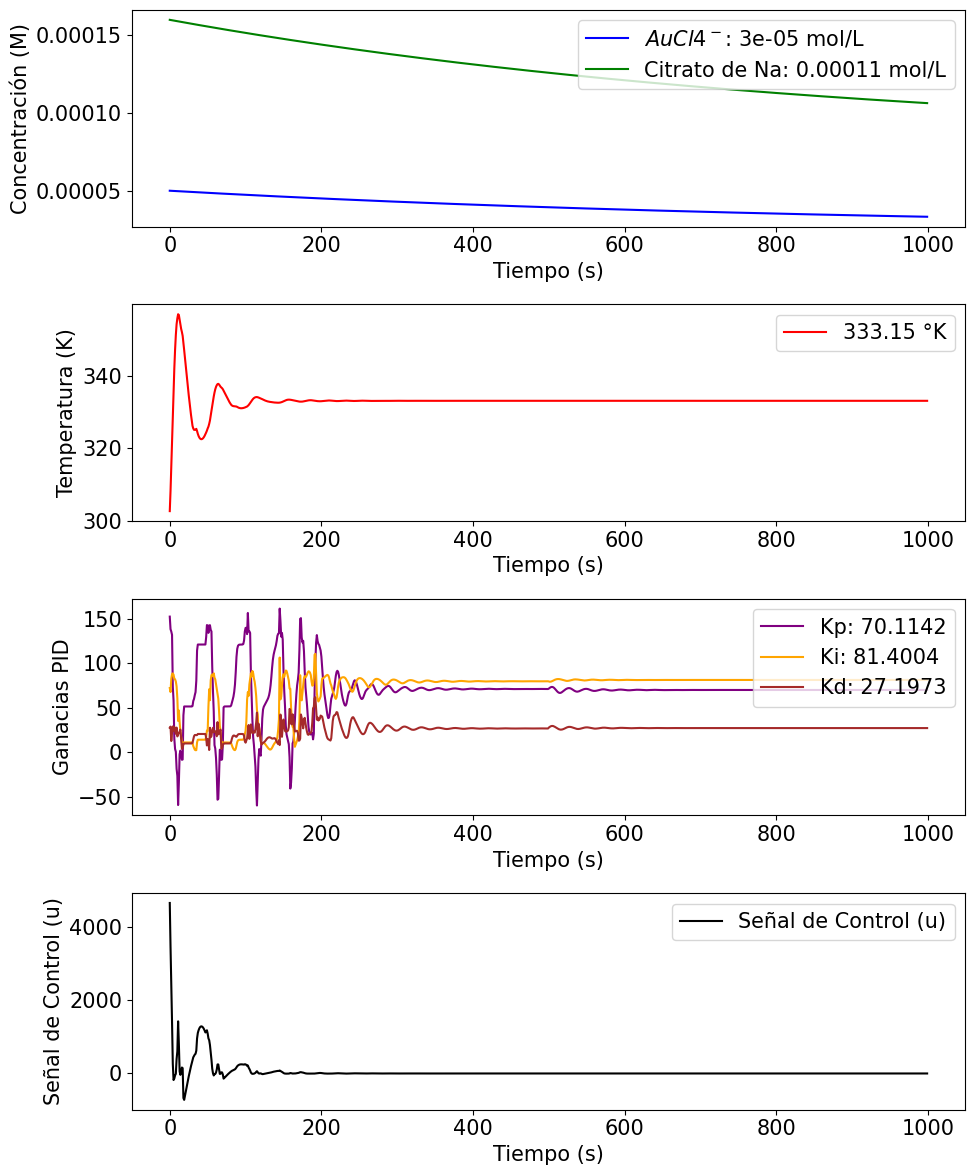

In [6]:
simulate_real_time("temperatura_entrada_citrato", 290, 500)


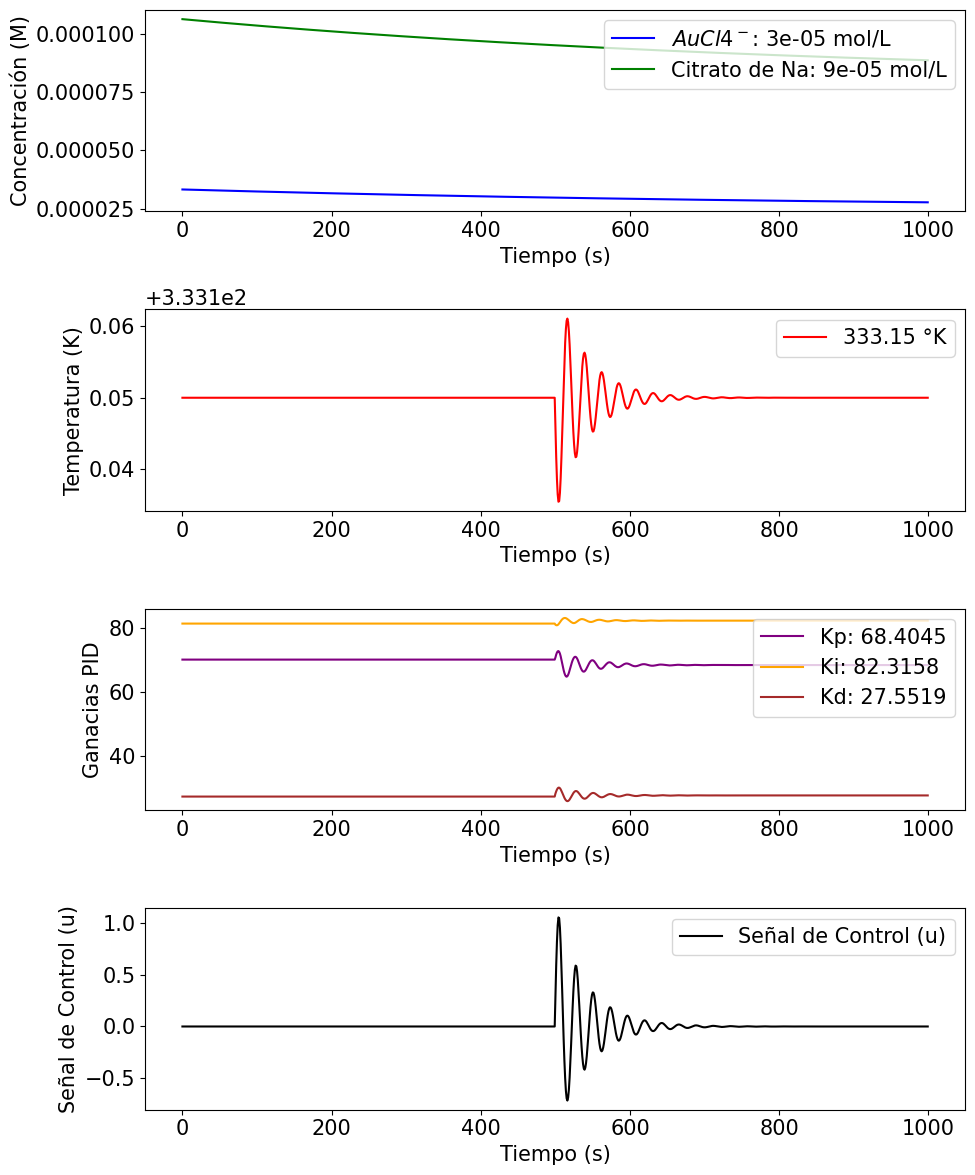

In [13]:
simulate_real_time("temperatura_entrada_citrato", 290, 500)


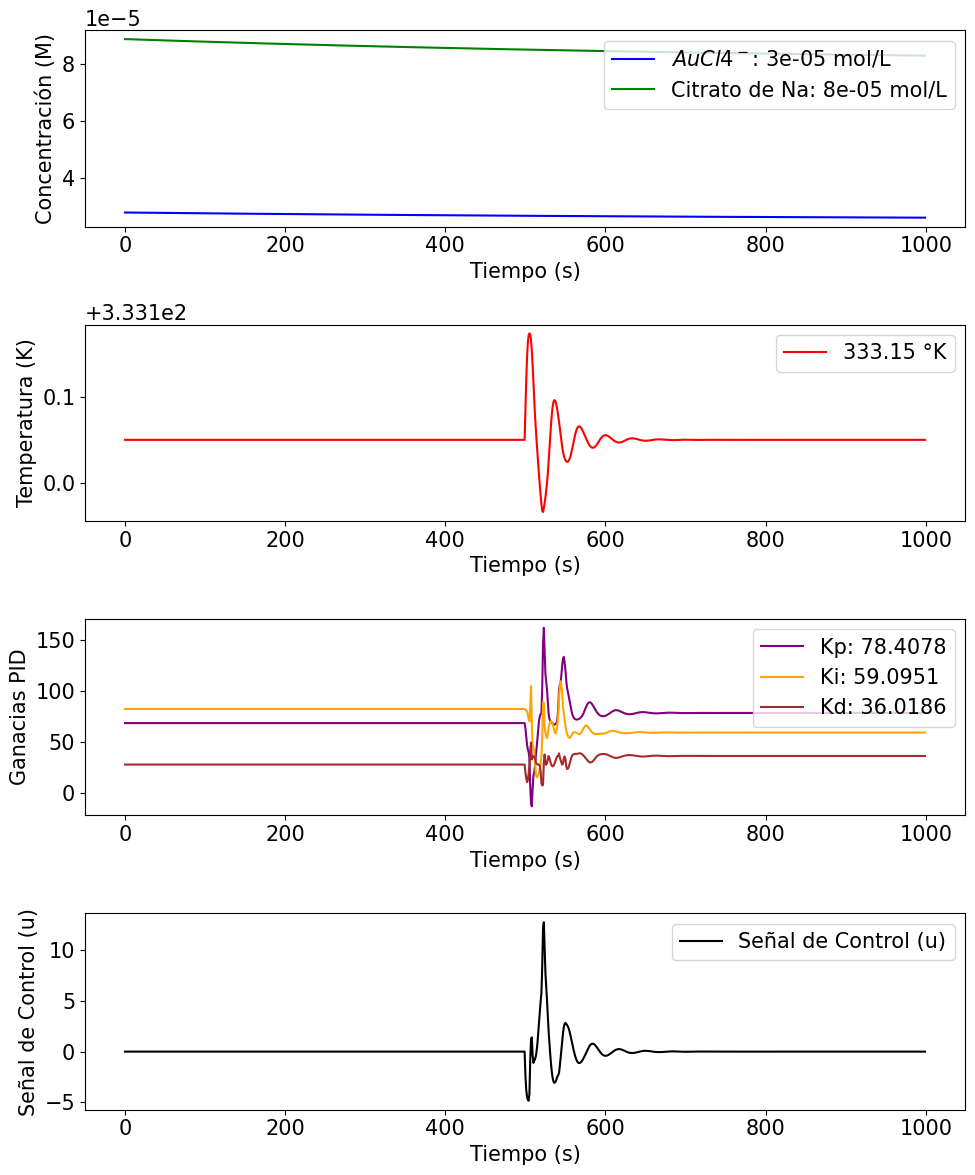

In [14]:
simulate_real_time(perturb_type="temperatura_entrada_citrato", 
                  perturb_value=360, 
                  perturb_step=500)

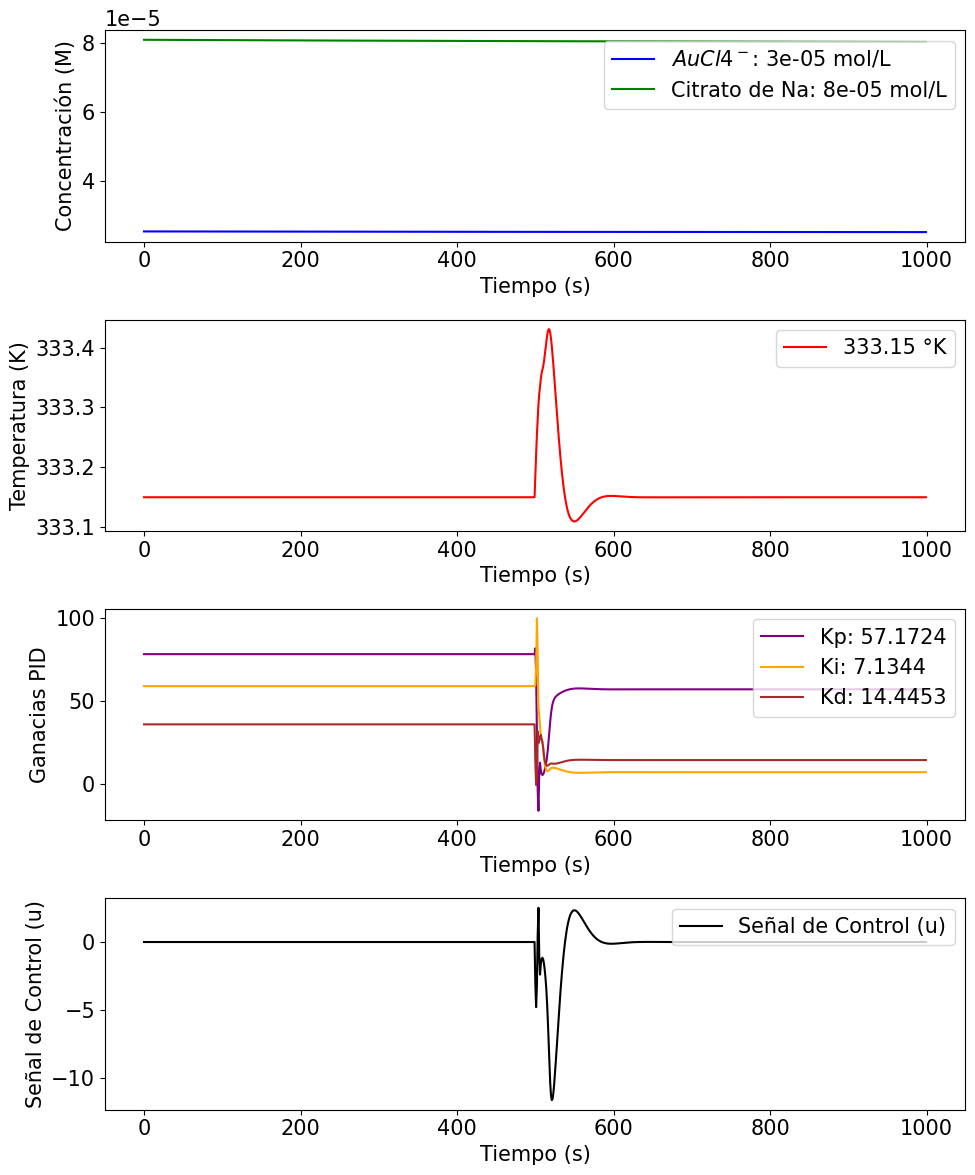

In [16]:
simulate_real_time(perturb_type="temperatura_entrada_aucl4", 
                  perturb_value=360, 
                  perturb_step=500)